# Import Libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
from scipy.fftpack import fft
import scipy
import seaborn as sns
import mycnn
import svcmodel

In [3]:
import sklearn.linear_model as lm
import tensorflow as tf
import sklearn.svm as svm

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [5]:
import sklearn.preprocessing as pproc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import normalize

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Import The Dataset

In [7]:
data_train = pd.read_csv('exoTrain.csv')
data_test = pd.read_csv('exoTest.csv')

## Permute The Dataset

In [8]:
data_train = np.random.permutation(np.asarray(data_train))
data_test = np.random.permutation(np.asarray(data_test))

### Get the Label column and delate the class column and rescale

In [9]:
y1 = data_train[:,0]
y2 = data_test[:,0]

In [10]:
y_train = (y1-min(y1))/(max(y1)-min(y1))
y_test = (y2-min(y2))/(max(y2)-min(y2))

data_train = np.delete(data_train,1,1)
data_test = np.delete(data_test,1,1)

### Print the light curve

In [11]:
time = np.arange(len(data_train[0])) * (36/60)  # Time in hours

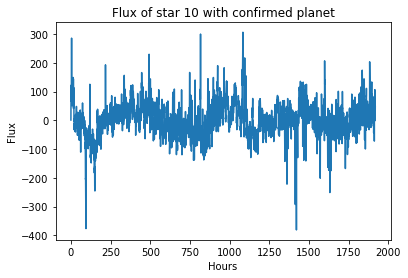

In [27]:
plt.figure()
plt.title('Flux of star 10 with confirmed planet')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , data_train[10] )     #change the number to plot what you want

### Normalized data

In [13]:
data_train_norm = normalize(data_train)
data_test_norm = normalize(data_test)

### Defining a Gaussian Filter to applyon the Normalized dara to smooth it out

In [14]:
def gauss_filter(dataset,sigma):
    
    dts = []
    
    for x in range(dataset.shape[0]):
        dts.append(gaussian_filter(dataset[x], sigma))
    
    return np.asarray(dts)

In [15]:
# apply the  filter
data_train_gaussian = gauss_filter(data_train_norm,7.0)
data_test_gaussian = gauss_filter(data_test_norm,7.0)

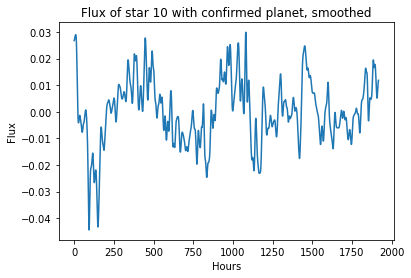

In [28]:
#print the light curves smoothed
plt.figure()
plt.title('Flux of star 10 with confirmed planet, smoothed')
plt.ylabel('Flux')
plt.xlabel('Hours')
plt.plot( time , data_train_gaussian[10])

In [18]:
# apply FFT to the data smoothed
frequency = np.arange(len(data_train[0])) * (1/(36.0*60.0))

data_train_fft1 = scipy.fft.fft2(data_train_norm, axes=1)
data_test_fft1 = scipy.fft.fft2(data_test_norm, axes=1)

data_train_fft = np.abs(data_train_fft1)   #calculate the abs value
data_test_fft = np.abs(data_test_fft1)

In [19]:
#get the length of the FFT data, make something here below in order to make the sequences of the same size
# only if they have differet dimensions

len_seq = len(data_train_fft[0])

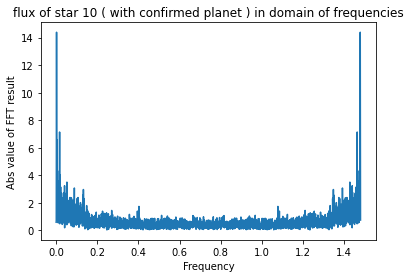

In [31]:
#plot the FFT of the signals
plt.figure()
plt.title('flux of star 10 ( with confirmed planet ) in domain of frequencies')
plt.ylabel('Abs value of FFT result')
plt.xlabel('Frequency')
plt.plot( frequency, data_train_fft[10] )

In [32]:
#oversampling technique to the data
rm = RandomOverSampler(sampling_strategy=0.5)
data_train_ovs, y_train_ovs = rm.fit_sample( data_train_fft, y_train)

In [33]:
#recap dataset after oversampling
print("After oversampling, counts of label '1': {}".format(sum(y_train_ovs==1)))
print("After oversampling, counts of label '0': {}".format(sum(y_train_ovs==0)))

After oversampling, counts of label '1': 2525
After oversampling, counts of label '0': 5050


In [34]:
# Implementing The Neural Networl

In [35]:
#reshape the data for the neural network model
data_train_ovs = np.asarray(data_train_ovs)
data_test_fft = np.asarray(data_test_fft)

data_train_ovs_nn = data_train_ovs.reshape((data_train_ovs.shape[0], data_train_ovs.shape[1], 1))
data_test_fft_nn = data_test_fft.reshape((data_test_fft.shape[0], data_test_fft.shape[1], 1))

In [36]:
#create CNN model and run it
model = mycnn.mycnn(len_seq)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])

print(model.summary())

history = model.fit(data_train_ovs_nn, y_train_ovs , epochs=15, batch_size = 10, validation_data=(data_test_fft_nn, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3190, 256)         2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 638, 256)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 638, 256)          1024      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 633, 340)          522580    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 127, 340)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 340)          1360      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 256)          3

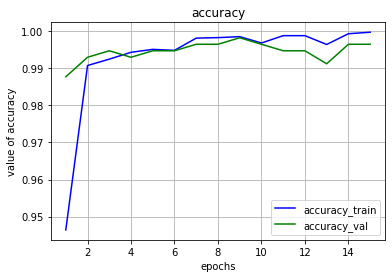

In [37]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label='accuracy_train')
plt.plot(epochs, acc_val, 'g', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

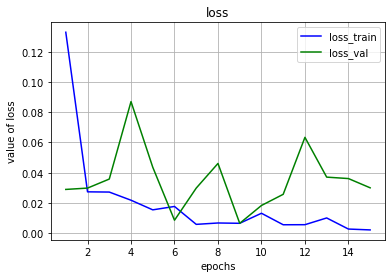

In [38]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, loss, 'b', label='loss_train')
plt.plot(epochs, loss_val, 'g', label='loss_val')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('value of loss')
plt.legend()
plt.grid()
plt.show()

accuracy :  0.9964912280701754
                         precision    recall  f1-score   support

 NO exoplanet confirmed       1.00      1.00      1.00       565
YES exoplanet confirmed       1.00      0.60      0.75         5

               accuracy                           1.00       570
              macro avg       1.00      0.80      0.87       570
           weighted avg       1.00      1.00      1.00       570



<AxesSubplot:>

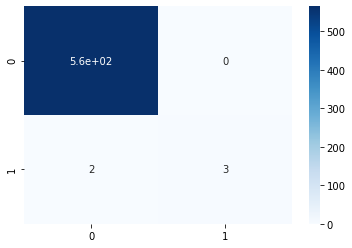

In [39]:
#predict the test set and plot results
y_test_pred = model.predict(data_test_fft_nn)
y_test_pred = (y_test_pred > 0.5)


accuracy = accuracy_score(y_test, y_test_pred)
print("accuracy : ", accuracy)

print(classification_report(y_test, y_test_pred, target_names=["NO exoplanet confirmed","YES exoplanet confirmed"]))

conf_matrix = confusion_matrix([int(x) for x in y_test ], [int(y) for y in y_test_pred ])
sns.heatmap(conf_matrix, annot=True, cmap='Blues')

In [33]:
print(conf_matrix)

[[561   4]
 [  2   3]]
